In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# Load CSV
labels_df = pd.read_csv('/kaggle/input/brats-2021-miccai/train_labels.csv')

# Remove problematic subjects
problematic_ids = ['00109', '00123', '00709']
labels_df = labels_df[~labels_df['BraTS21ID'].isin([int(i) for i in problematic_ids])]

# Confirm shape
print("Filtered labels:", labels_df.shape)
labels_df.head()


Filtered labels: (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [3]:
def load_dicom_images(path, img_size=(128, 128), num_slices=64):
    slices = []
    files = sorted(os.listdir(path))
    for file in files:
        file_path = os.path.join(path, file)
        try:
            dcm = pydicom.dcmread(file_path)
            img = dcm.pixel_array.astype(np.float32)
            img = cv2.resize(img, img_size)
            slices.append(img)
        except:
            continue
    
    # Ensure consistent number of slices
    if len(slices) == 0:
        return None
    slices = np.stack(slices, axis=0)  # Shape: (depth, H, W)
    
    if slices.shape[0] > num_slices:
        # Center crop
        start = (slices.shape[0] - num_slices) // 2
        slices = slices[start:start+num_slices]
    elif slices.shape[0] < num_slices:
        # Pad with zeros
        pad_amount = num_slices - slices.shape[0]
        pad_before = pad_amount // 2
        pad_after = pad_amount - pad_before
        padding = ((pad_before, pad_after), (0, 0), (0, 0))
        slices = np.pad(slices, padding, mode='constant')
    
    return slices

def process_subject(subject_id, base_dir='/kaggle/input/brats-2021-miccai/train', img_size=(128, 128), num_slices=64):
    modalities = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    subject_path = os.path.join(base_dir, f"{subject_id:05d}")
    
    modality_arrays = []
    for modality in modalities:
        modality_path = os.path.join(subject_path, modality)
        img_stack = load_dicom_images(modality_path, img_size, num_slices)
        if img_stack is not None:
            modality_arrays.append(img_stack)
    
    if len(modality_arrays) == 4:
        return np.stack(modality_arrays, axis=0)  # Shape: (4, slices, H, W)
    else:
        return None

# Preprocess all subjects
preprocessed_data = []
labels = []

for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    subject_id = row['BraTS21ID']
    label = row['MGMT_value']
    
    subject_data = process_subject(subject_id)
    if subject_data is not None:
        preprocessed_data.append(subject_data)
        labels.append(label)

X = np.array(preprocessed_data)  # Shape: (N, 4, slices, H, W)
y = np.array(labels)

print("Final data shape:", X.shape)
print("Labels shape:", y.shape)

100%|██████████| 582/582 [44:37<00:00,  4.60s/it] 


Final data shape: (582, 4, 64, 128, 128)
Labels shape: (582,)


In [4]:
np.save("X_train.npy", X)
np.save("y_train.npy", y)


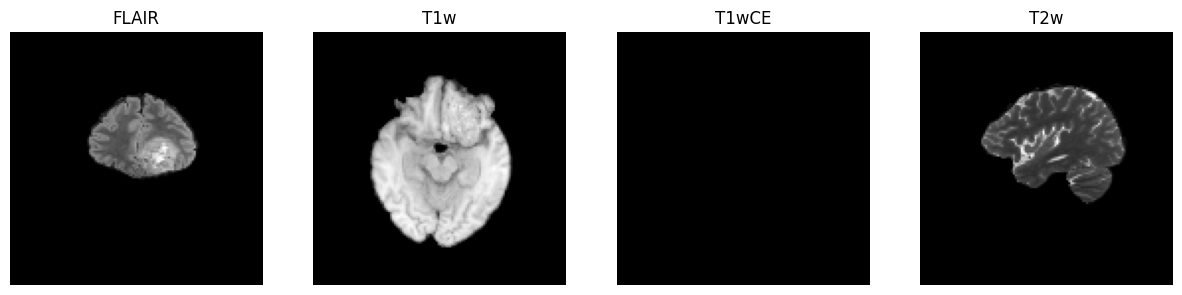

In [5]:
def show_modalities(data, slice_index=20):
    modalities = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    for i in range(4):
        axes[i].imshow(data[i, slice_index], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis('off')
    plt.show()

# Visualize a random subject
show_modalities(X[0])


In [6]:
# Example: split into 5 parts
'''split_X = np.array_split(X, 30)

for i, part in enumerate(split_X):
    np.save(f'/kaggle/working/X_train_part0{i}.npy', part)'''


"split_X = np.array_split(X, 30)\n\nfor i, part in enumerate(split_X):\n    np.save(f'/kaggle/working/X_train_part0{i}.npy', part)"